In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
%env GOOGLE_APPLICATION_CREDENTIALS = ../dsi-capstone-f19-group-1-198add732865.json

env: GOOGLE_APPLICATION_CREDENTIALS=../dsi-capstone-f19-group-1-198add732865.json


In [5]:
%load_ext google.cloud.bigquery

In [6]:
%%bigquery df_frequency
WITH day_topic AS (
    SELECT
      A.id,
      B.day_of_tweet,
      B.full_text,
      A.dominant_topic,
      A.topic_perc_contrib AS tweet_index,
      B.is_retweet
    FROM topic_modeling.topics_only_brown AS A
    INNER JOIN tweets.all_valid_tweets AS B
    ON A.id = B.id
)
SELECT
    dominant_topic,
    COUNT(*) AS total_tweets,
    ROUND(SUM(tweet_index),0) AS total_tweet_index,
    SUM(IF(is_retweet, 0, 1)) AS original_tweets,
    ROUND(SUM(IF(is_retweet, 0, tweet_index)),0) AS original_tweet_index
FROM day_topic
GROUP BY dominant_topic
ORDER BY total_tweets DESC

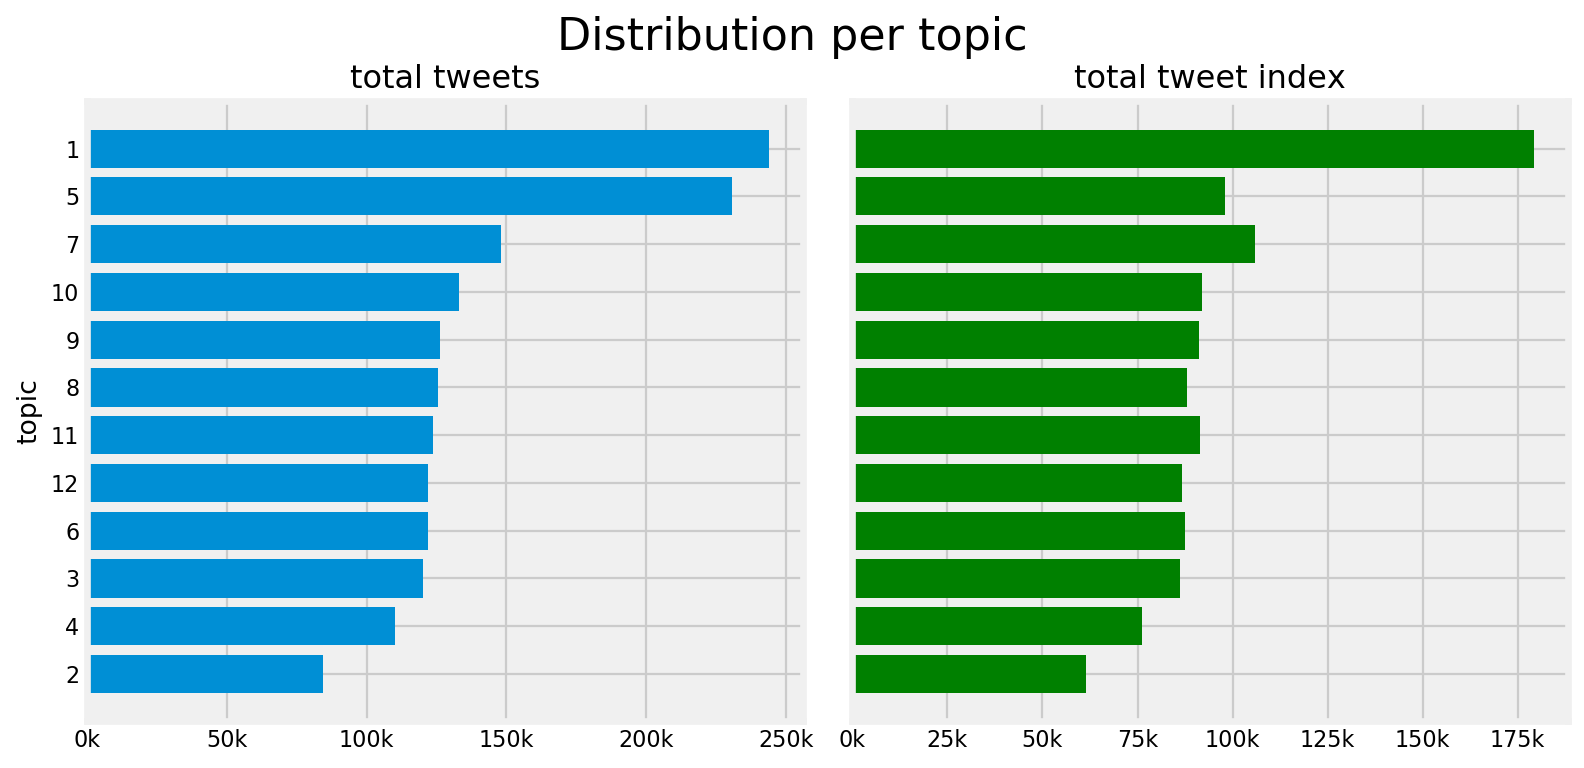

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=160)

topics = df_frequency['dominant_topic']
tweets = df_frequency['total_tweets']
index = df_frequency['total_tweet_index']

y_pos = np.arange(len(topics))

ax[0].barh(y_pos, tweets, align='center')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(topics)
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([str(int(xtick / 1000)) + 'k' for xtick in xticks])
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_title('total tweets')
ax[0].set_ylabel('topic')

ax[1].barh(y_pos, index, align='center', color='green')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels([])
xticks = ax[1].get_xticks()
ax[1].set_xticklabels([str(int(xtick / 1000)) + 'k' for xtick in xticks])
ax[1].invert_yaxis() 
ax[1].set_title('total tweet index')

plt.subplots_adjust(wspace=0.1, hspace=0)

plt.suptitle('Distribution per topic', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

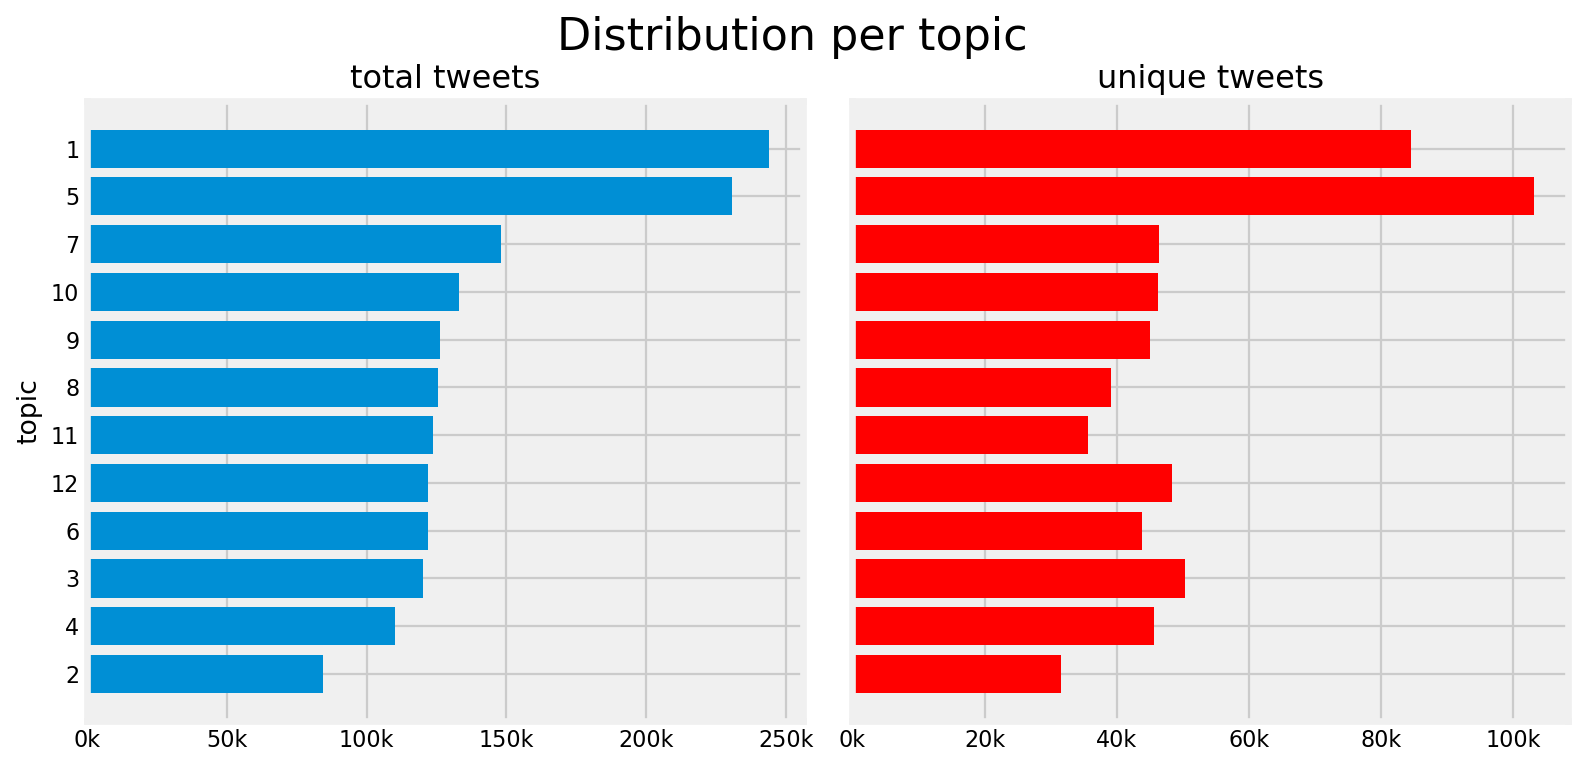

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=160)

unique = df_frequency['original_tweets']

y_pos = np.arange(len(topics))

ax[0].barh(y_pos, tweets, align='center')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(topics)
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([str(int(xtick / 1000)) + 'k' for xtick in xticks])
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_title('total tweets')
ax[0].set_ylabel('topic')

ax[1].barh(y_pos, unique, align='center', color='red')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels([])
xticks = ax[1].get_xticks()
ax[1].set_xticklabels([str(int(xtick / 1000)) + 'k' for xtick in xticks])
ax[1].invert_yaxis() 
ax[1].set_title('unique tweets')

plt.subplots_adjust(wspace=0.1, hspace=0)

plt.suptitle('Distribution per topic', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
%%bigquery df_topic_timeseries
WITH day_topic AS (
    SELECT
      A.id,
      B.day_of_tweet,
      B.full_text,
      A.dominant_topic,
      A.topic_perc_contrib AS tweet_index,
      B.is_retweet
    FROM topic_modeling.topics_only_brown AS A
    INNER JOIN tweets.all_valid_tweets AS B
    ON A.id = B.id
)
SELECT
    day_of_tweet,
    dominant_topic,
    COUNT(*) AS total_tweets,
    SUM(IF(is_retweet, 0, 1)) AS original_tweets
FROM day_topic
GROUP BY day_of_tweet, dominant_topic
ORDER BY day_of_tweet, dominant_topic DESC

In [10]:
df_total_ts = pd.pivot_table(df_topic_timeseries,
                             values='total_tweets',
                             index=['day_of_tweet'],
                             columns=['dominant_topic'])

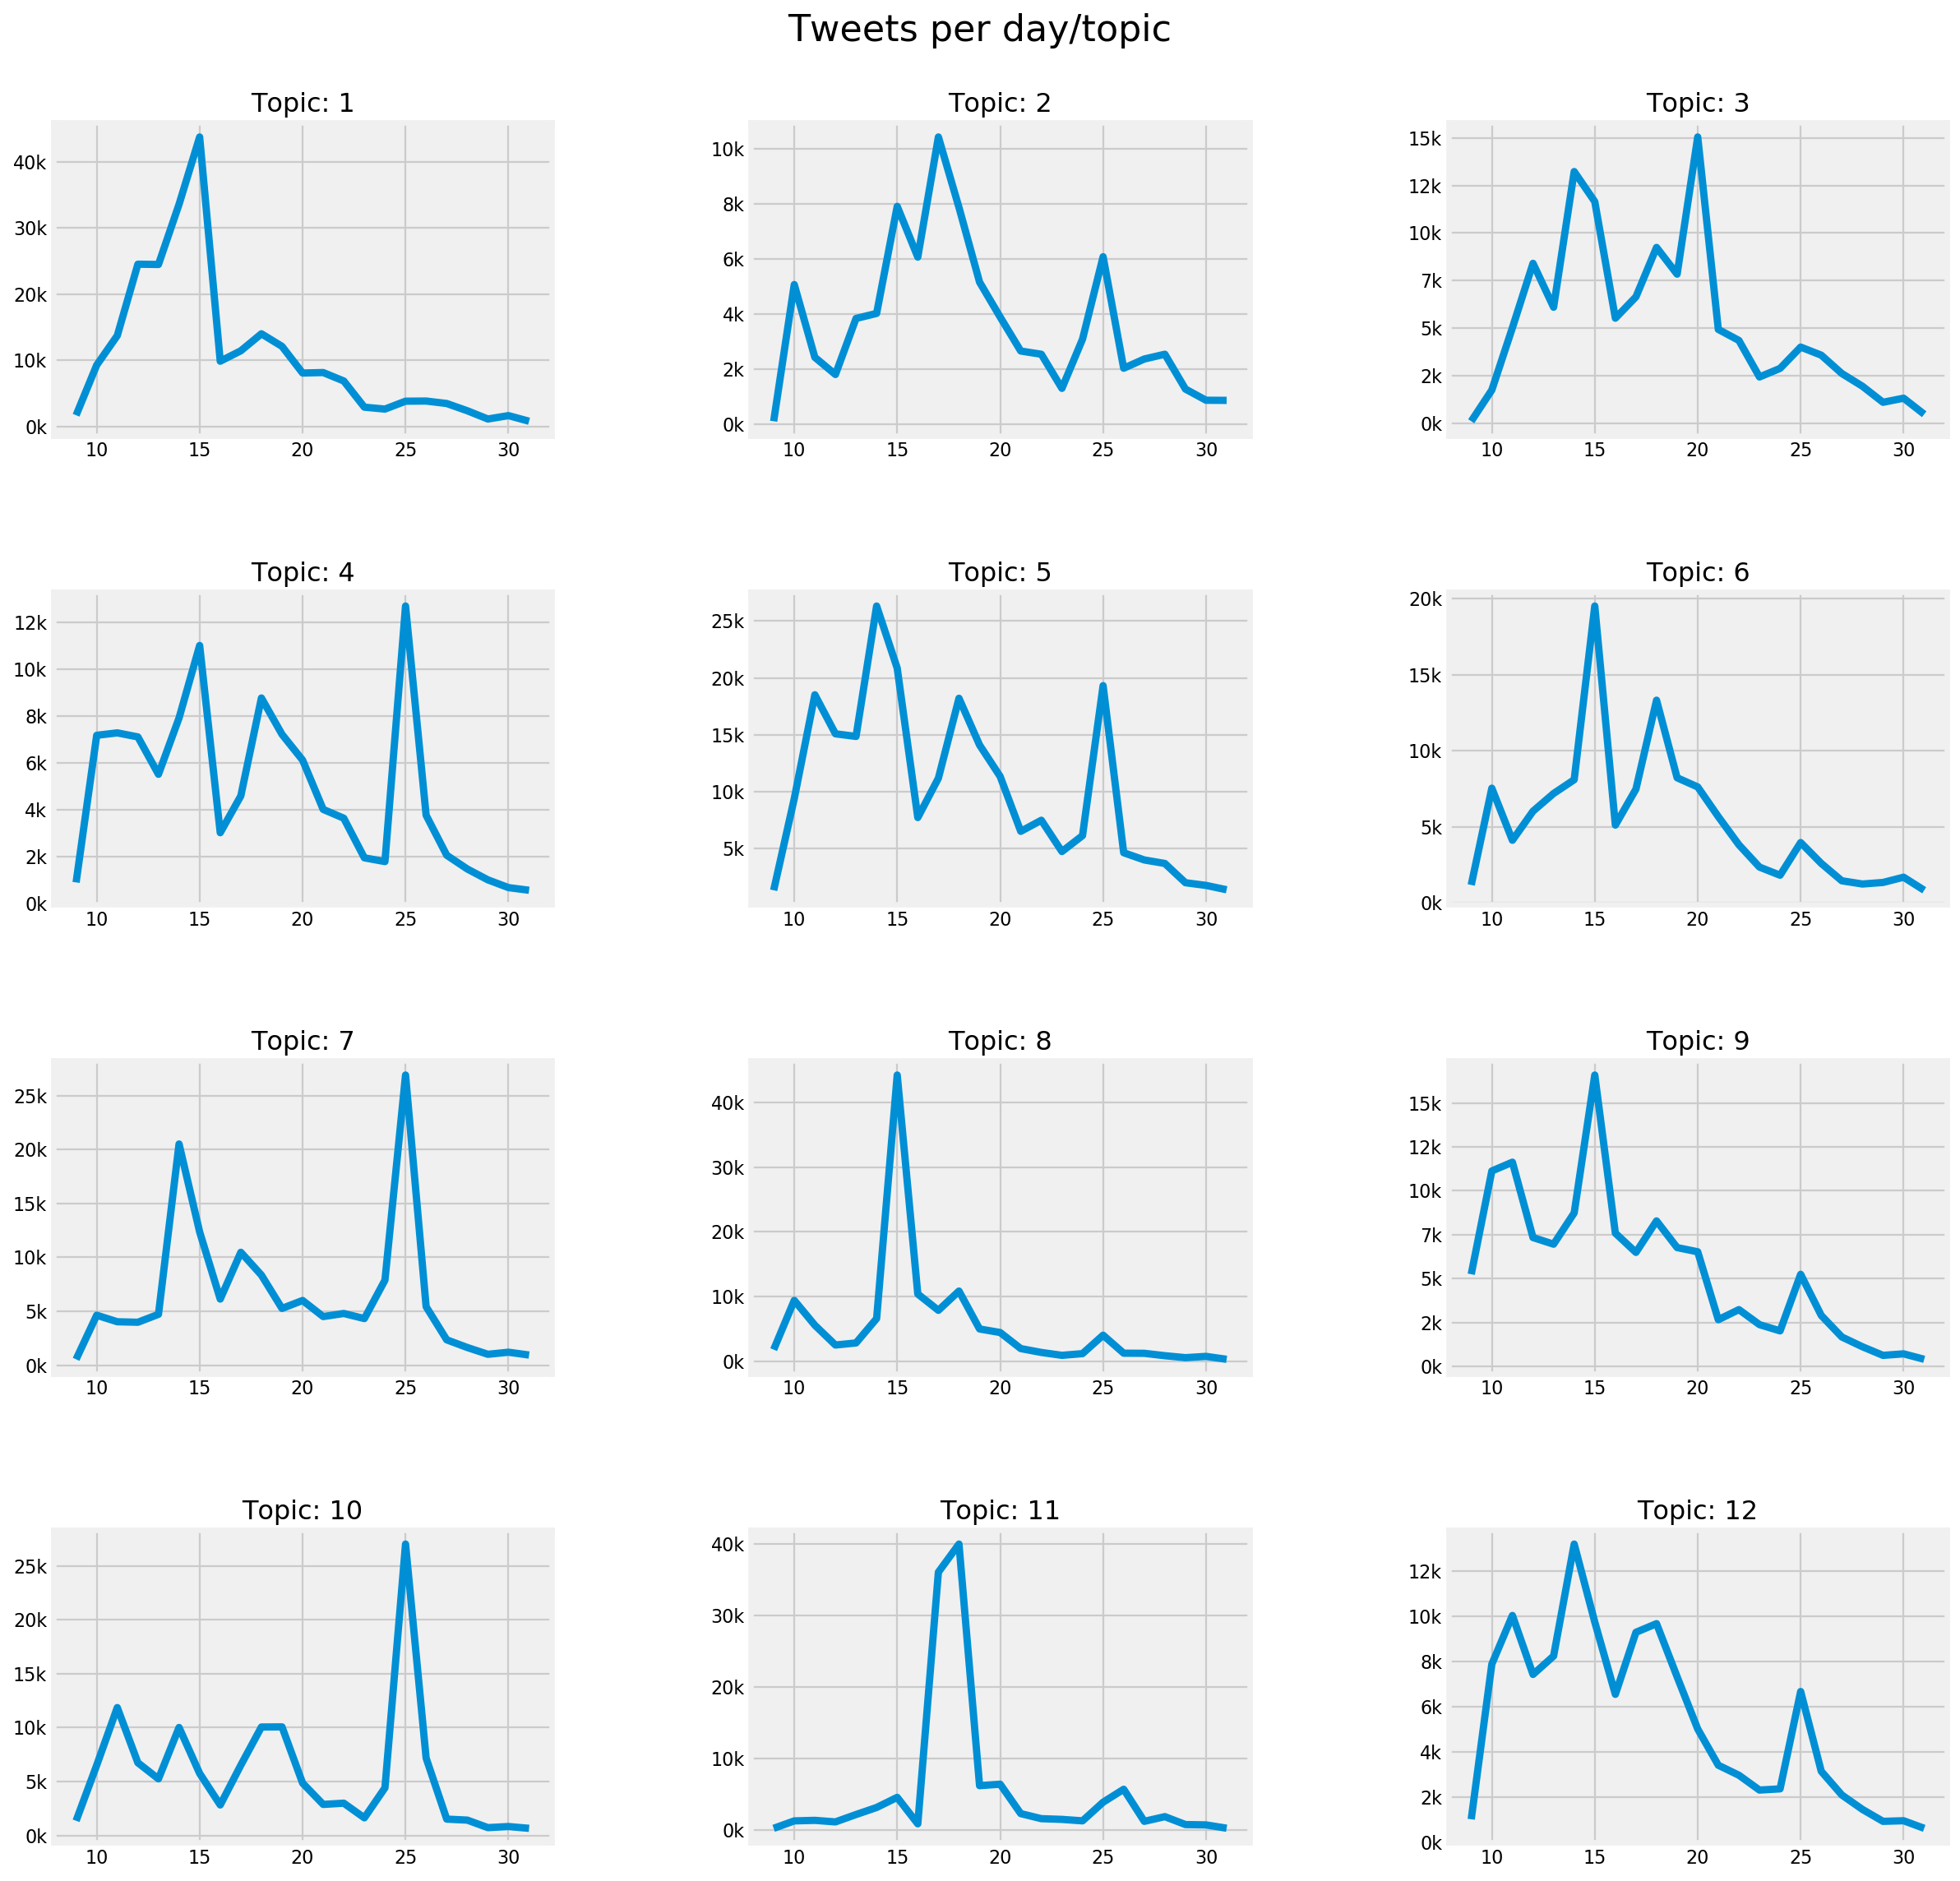

In [11]:
fig, ax = plt.subplots(4,3,figsize=(15,15), dpi=160)
days = list(df_total_ts.index)

def ks_label(tick):
    if tick == 0 or tick >= 1000:
        return(str(int(tick / 1000)) + 'k')
    else:
        return(str(round(tick / 1000, 1)) + 'k')

for i in range(4):
    for j in range(3):
        index = 3*i + j
        ax[i,j].plot(days, df_total_ts[index+1])
        yticks = ax[i,j].get_yticks()
        ax[i,j].set_yticklabels([ks_label(ytick) for ytick in yticks])
        ax[i,j].set_title('Topic: %s' % (str(int(index+1))))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.suptitle('Tweets per day/topic', fontsize=20)
plt.show()

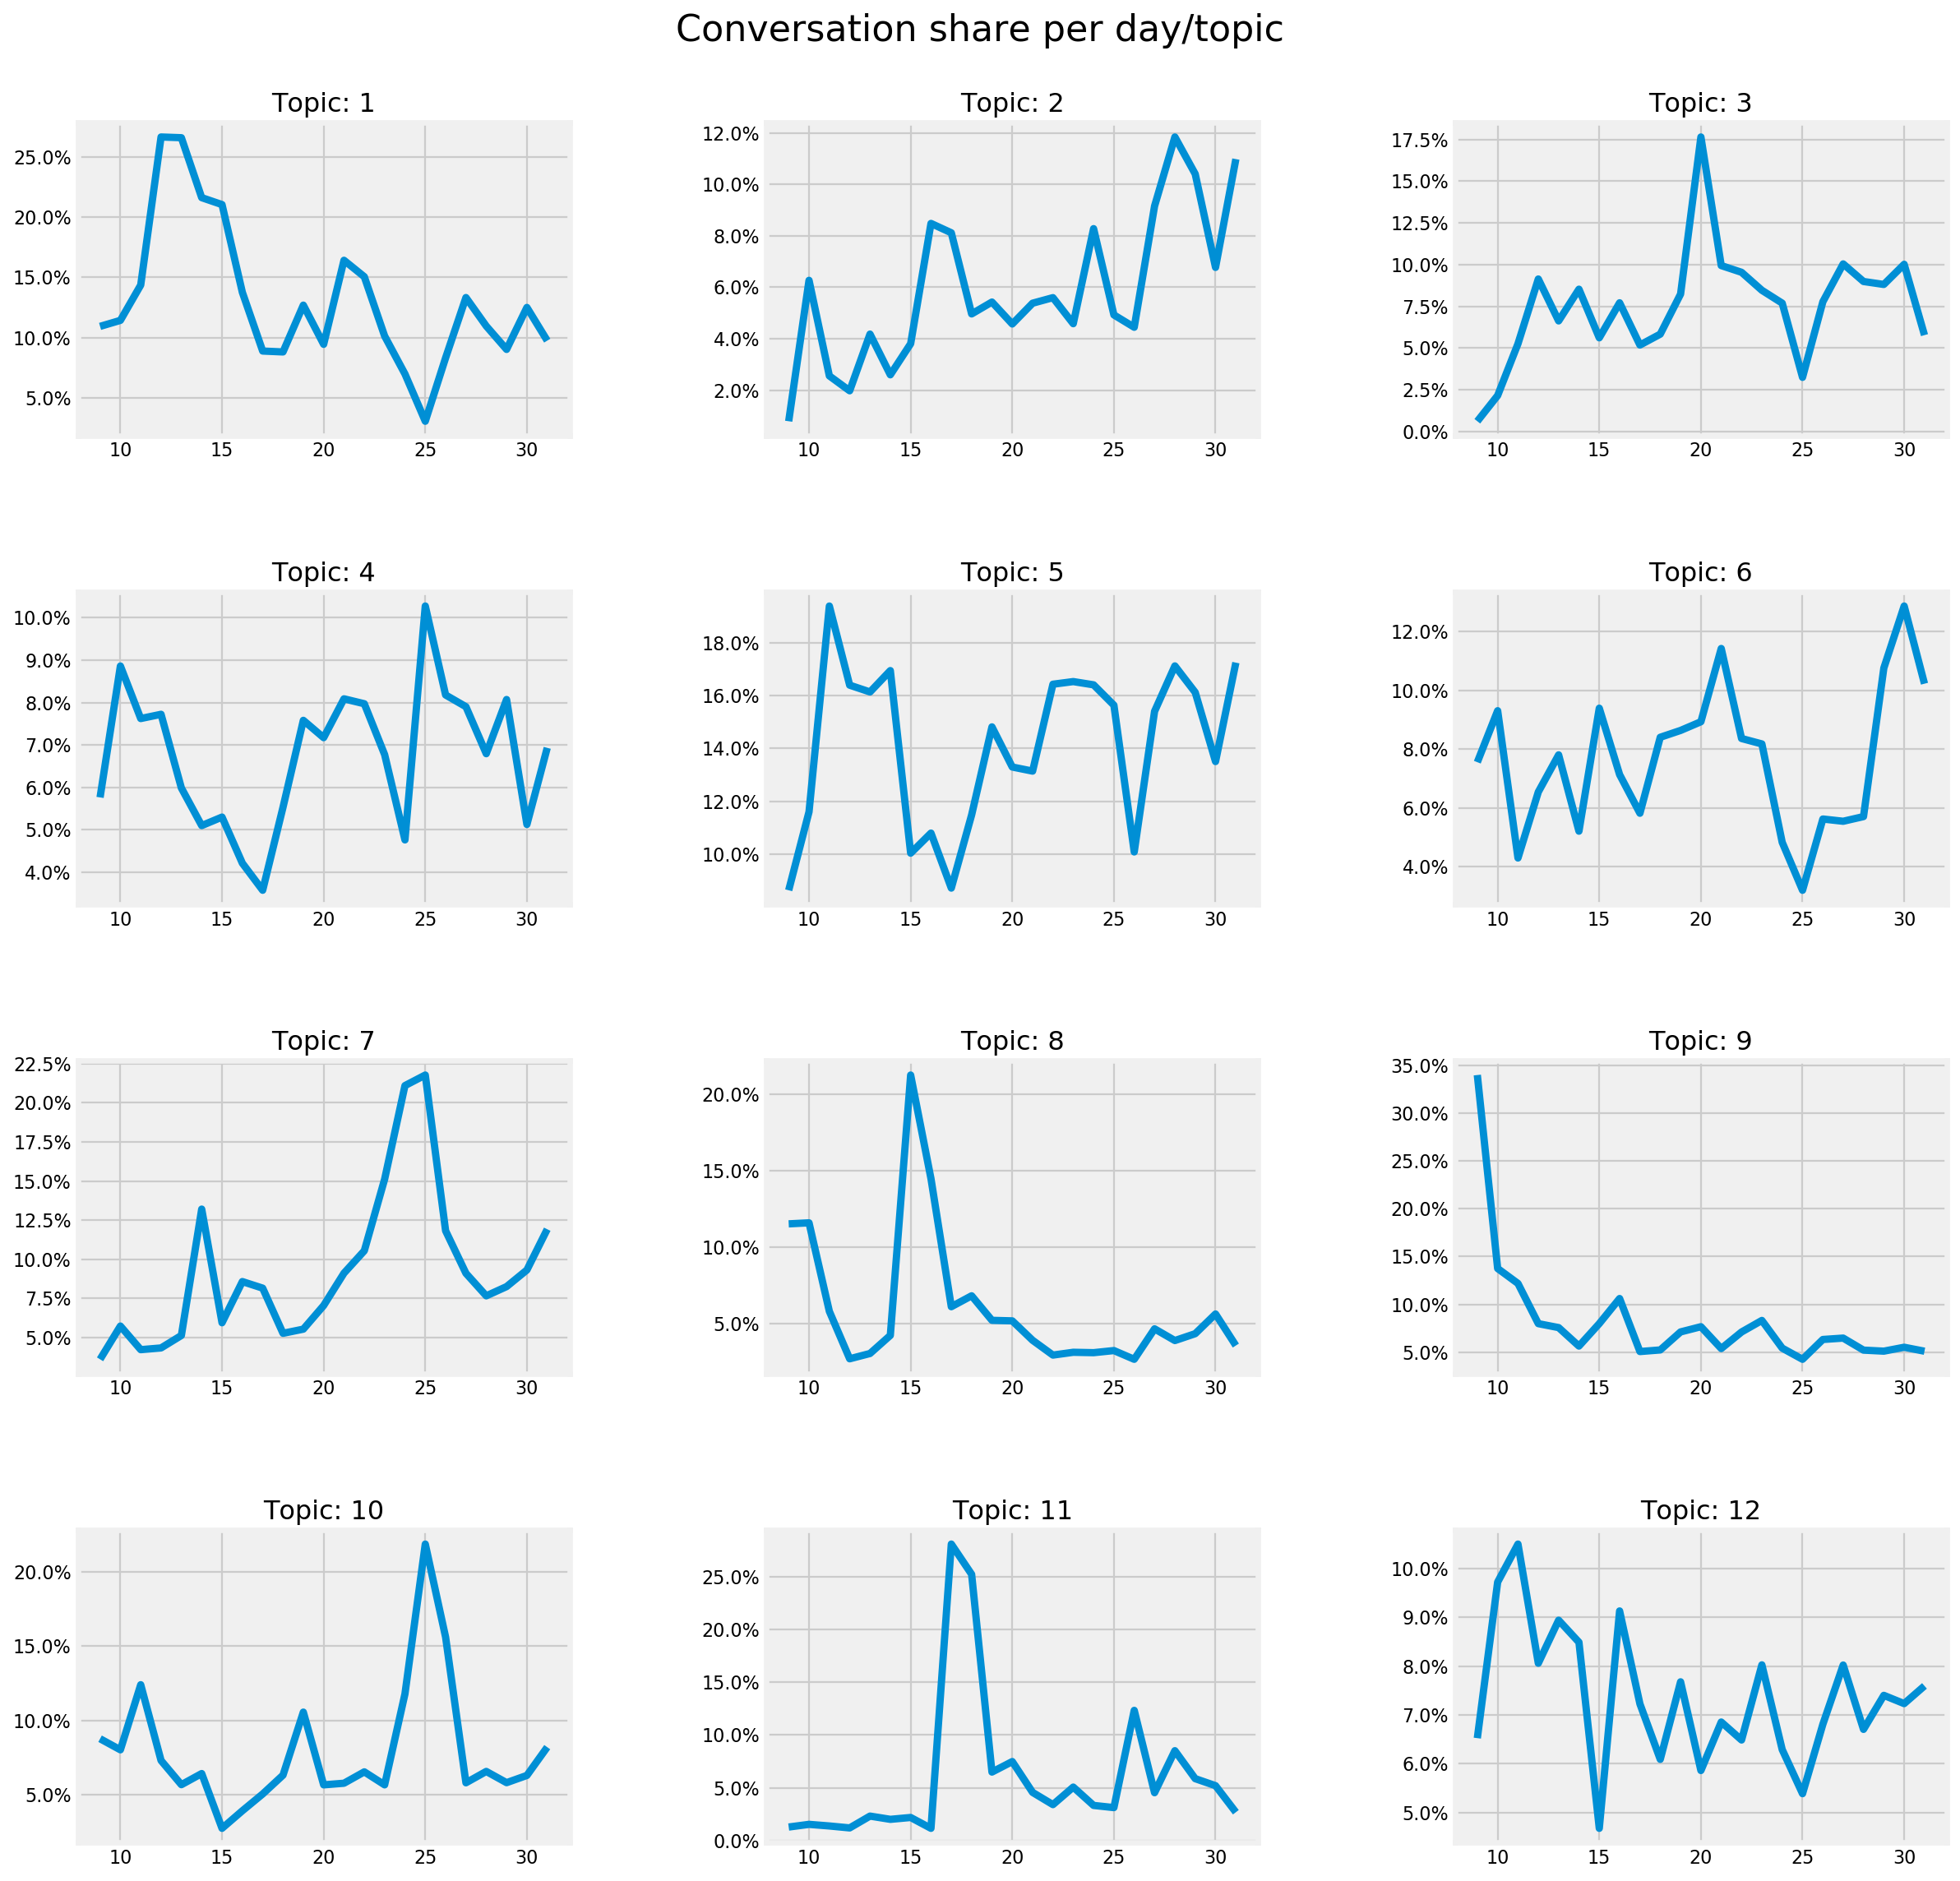

In [12]:
df_perc_ts = df_total_ts.apply(lambda x:x/np.sum(x), axis = 1)
fig, ax = plt.subplots(4,3,figsize=(15,15), dpi=160,)
days = list(df_perc_ts.index)

for i in range(4):
    for j in range(3):
        index = 3*i + j
        ax[i,j].plot(days, df_perc_ts[index+1])
        yticks = ax[i,j].get_yticks()
        ax[i,j].set_yticklabels([str(round(100*ytick,1)) + '%' for ytick in yticks])
        ax[i,j].set_title('Topic: %s' % (str(int(index+1))))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.suptitle('Conversation share per day/topic', fontsize=20)
plt.show()

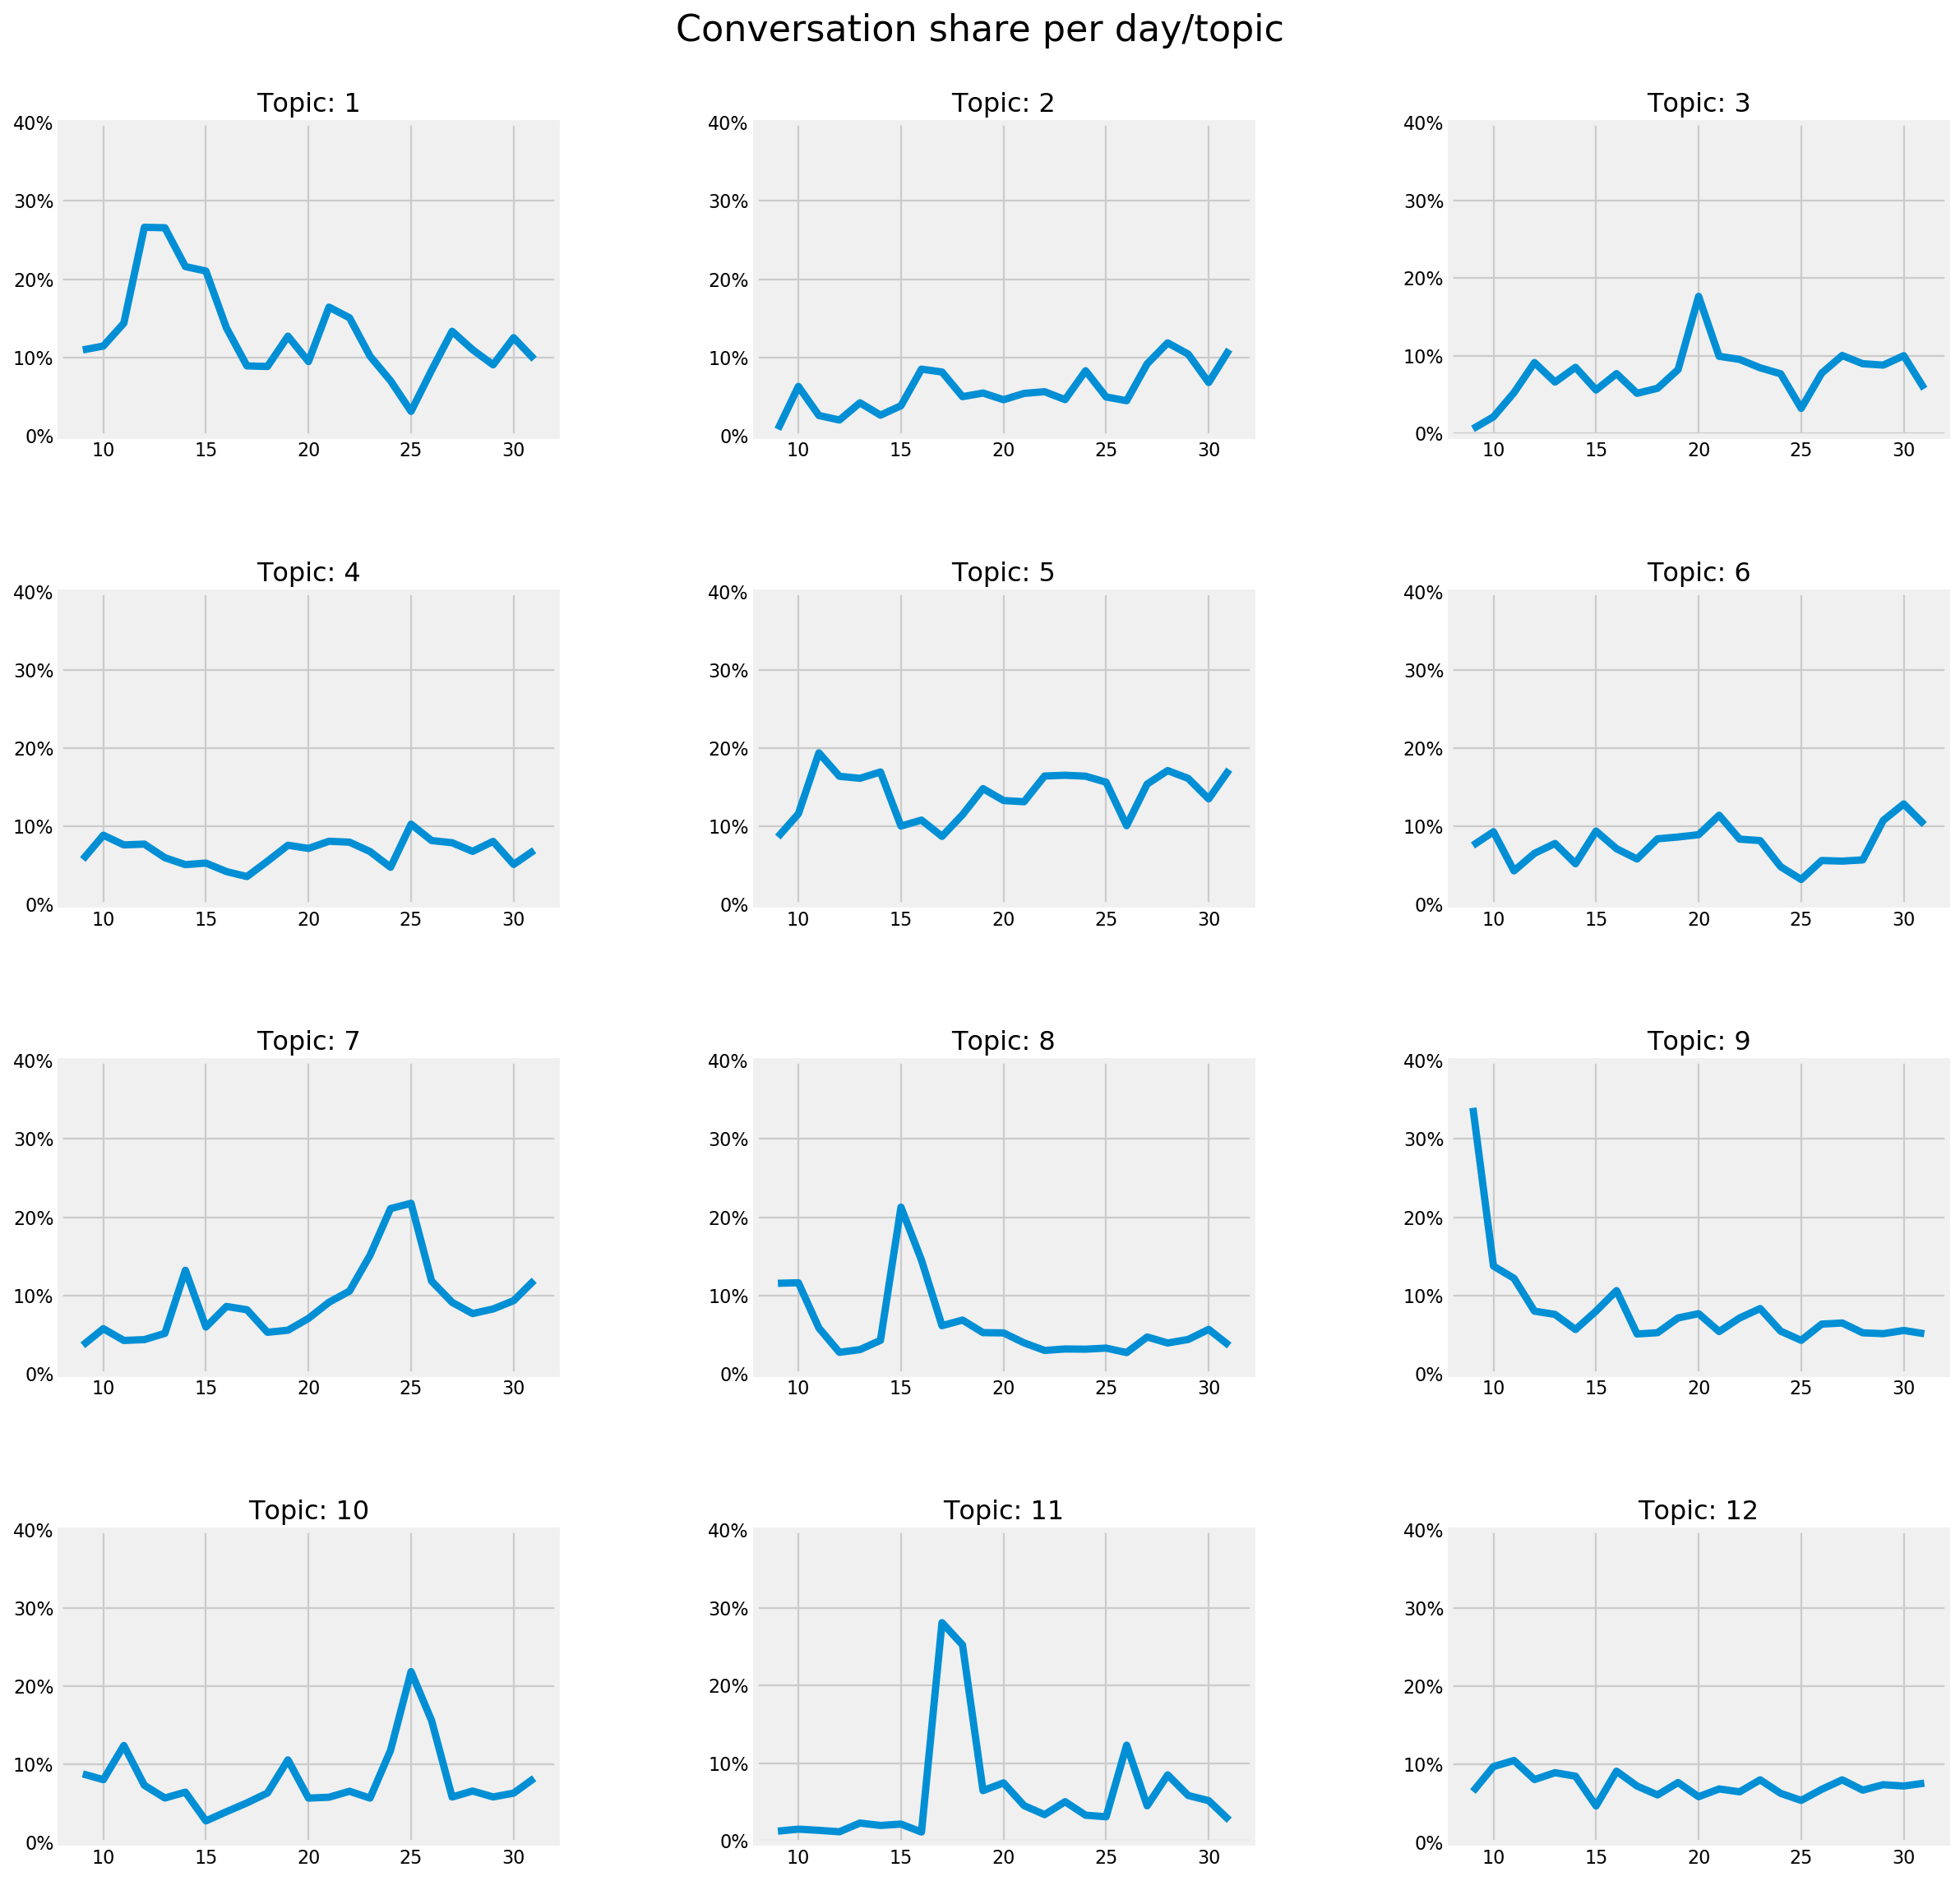

In [13]:
df_perc_ts = df_total_ts.apply(lambda x:x/np.sum(x), axis = 1)
fig, ax = plt.subplots(4,3,figsize=(15,15), dpi=160,)
days = list(df_perc_ts.index)

for i in range(4):
    for j in range(3):
        index = 3*i + j
        ax[i,j].plot(days, df_perc_ts[index+1])
        ax[i,j].set_yticks(np.arange(0,0.5,0.1))
        ax[i,j].set_yticklabels([str(int(100*ytick)) + '%' for ytick in np.arange(0,0.5,0.1)])
        ax[i,j].set_title('Topic: %s' % (str(int(index+1))))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.suptitle('Conversation share per day/topic', fontsize=20)
plt.show()